# HUMIDITY TAHMİN MODELİ

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [3]:
dataset_5M = pd.read_csv("datasets\I_5M.csv",header =0)
dataset_5M.columns = ["Temperature","Humidity","Lux","IAQ","SharpIN","SharpOut","Sharp_Difference","PIR"]

In [4]:
dataset_5M.describe()

,Temperature,Humidity,Lux,IAQ,SharpIN,SharpOut,Sharp_Difference,PIR
count,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000,4925.000000
mean,19.480891,31.240105,54.348988,80.505897,1.022132,-0.447513,0.574619,1.170761
std,4.093584,5.893274,91.718155,24.965028,4.277218,1.521020,3.675888,3.971092
min,0.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-16.000000,0.000000
25%,16.700000,27.675000,0.000000,74.000000,0.000000,0.000000,0.000000,0.000000
50%,18.868750,31.550000,0.000000,78.000000,0.000000,0.000000,0.000000,0.000000
75%,21.950000,35.562500,68.387813,99.999023,0.000000,0.000000,0.000000,0.000000
max,33.412500,47.825000,429.667350,194.111000,99.000000,0.000000,98.000000,54.000000


In [5]:
dataset_5M.drop(dataset_5M.columns[[7,6,5,4]], axis=1, inplace=True)

In [6]:
values = dataset_5M.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
dataset_5M.describe()

,Temperature,Humidity,Lux,IAQ
count,4925.000000,4925.000000,4925.000000,4925.000000
mean,19.480891,31.240105,54.348988,80.505897
std,4.093584,5.893274,91.718155,24.965028
min,0.000000,0.000000,0.000000,0.000000
25%,16.700000,27.675000,0.000000,74.000000
50%,18.868750,31.550000,0.000000,78.000000
75%,21.950000,35.562500,68.387813,99.999023
max,33.412500,47.825000,429.667350,194.111000


In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [9]:
converted_time_series = series_to_supervised(scaled, 1, 1)

In [10]:
converted_time_series.drop(converted_time_series.columns[[4,6,7]], axis=1, inplace=True)
#sıcaklık nem ve ışık t leri drop edildi
#(t-1) -> 
#var2(t) -> predict edilcek
converted_time_series.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var2(t)
1,0.882856,0.565048,0.488744,0.417287,0.563643
2,0.887954,0.563643,0.471602,0.421152,0.560115
3,0.900112,0.560115,0.434196,0.422117,0.561814
4,0.899551,0.561814,0.380808,0.421473,0.563251
5,0.897119,0.563251,0.334445,0.417303,0.564558


In [11]:
converted_time_series_values = converted_time_series.values

In [12]:
#train_min = 8300 #split ~ %80 train --- %20  test  
train_min = 4000

In [13]:
train_set = converted_time_series_values[:train_min,:]
test_set = converted_time_series_values[train_min:, :]

In [14]:
train_X, train_y = train_set[:, :-1], train_set[:, -1]
test_X, test_y = test_set[:, :-1], test_set[:, -1]

In [15]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4000, 1, 4) (4000,) (924, 1, 4) (924,)


Train on 4000 samples, validate on 924 samples
Epoch 1/75
 - 1s - loss: 0.6128 - val_loss: 0.4869
Epoch 2/75
 - 0s - loss: 0.3704 - val_loss: 0.1599
Epoch 3/75
 - 0s - loss: 0.1246 - val_loss: 0.1061
Epoch 4/75
 - 0s - loss: 0.0957 - val_loss: 0.0954
Epoch 5/75
 - 0s - loss: 0.0850 - val_loss: 0.0889
Epoch 6/75
 - 0s - loss: 0.0747 - val_loss: 0.0850
Epoch 7/75
 - 0s - loss: 0.0665 - val_loss: 0.0843
Epoch 8/75
 - 0s - loss: 0.0636 - val_loss: 0.0790
Epoch 9/75
 - 0s - loss: 0.0609 - val_loss: 0.0748
Epoch 10/75
 - 0s - loss: 0.0581 - val_loss: 0.0719
Epoch 11/75
 - 0s - loss: 0.0548 - val_loss: 0.0686
Epoch 12/75
 - 0s - loss: 0.0509 - val_loss: 0.0658
Epoch 13/75
 - 0s - loss: 0.0473 - val_loss: 0.0626
Epoch 14/75
 - 0s - loss: 0.0442 - val_loss: 0.0593
Epoch 15/75
 - 0s - loss: 0.0411 - val_loss: 0.0551
Epoch 16/75
 - 0s - loss: 0.0389 - val_loss: 0.0524
Epoch 17/75
 - 0s - loss: 0.0371 - val_loss: 0.0504
Epoch 18/75
 - 0s - loss: 0.0354 - val_loss: 0.0483
Epoch 19/75
 - 0s - loss: 

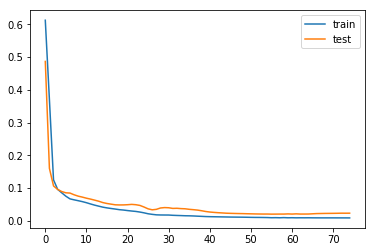

Train RMSE:   1
Test RMSE: 2.464


In [16]:
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))

  
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)



yhat_train = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
inv_yhat_train = concatenate((yhat_train, train_X[:, 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]
train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]
rmse_train = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
rmse_test = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Train RMSE: %3.f' % rmse_train)
print('Test RMSE: %.3f' % rmse_test)


#  DATA AUGMENTATION WITH GAUSSIAN NOISE


In [17]:
def lstm_model_Humidity_for_norm_dist(train_X_augmented,train_y_augmented,test_X,test_y):
    model_2 = Sequential()
    model_2.add(LSTM(50,activation='relu', input_shape=(train_X_augmented.shape[1], train_X_augmented.shape[2])))
    model_2.add(Dense(1))
    model_2.compile(loss='mae', optimizer='adam')
    # fit network
    history = model_2.fit(train_X_augmented, train_y_augmented, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    yhat = model_2.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]



    yhat_train_augmented = model_2.predict(train_X_augmented)
    train_X_augmented = train_X_augmented.reshape((train_X_augmented.shape[0], train_X_augmented.shape[2]))
    inv_yhat_train_augmented = concatenate((yhat_train_augmented, train_X_augmented[:, 1:]), axis=1)
    inv_yhat_train_augmented = scaler.inverse_transform(inv_yhat_train_augmented)
    inv_yhat_train_augmented = inv_yhat_train_augmented[:,0]

    train_y_augmented = train_y_augmented.reshape((len(train_y_augmented), 1))
    train_inv_y_augmented = concatenate((train_y_augmented, train_X_augmented[:, 1:]), axis=1)
    train_inv_y_augmented = scaler.inverse_transform(train_inv_y_augmented)
    train_inv_y_augmented = train_inv_y_augmented[:,0]



    rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_train = sqrt(mean_squared_error(train_inv_y_augmented, inv_yhat_train_augmented))

    print('Train RMSE: %.3f' % rmse_train)
    print('Test RMSE: %.3f' % rmse_test)
    return rmse_train

In [18]:
def noise(X, y, n, sigma):
    _X = X.copy()
    _y = y.copy()
    for _ in range(n):
        X = np.r_[X, _X + np.random.randn(*_X.shape)*sigma]
        y = np.r_[y, _y]
    return X, y

In [19]:
X = dataset_5M[['Temperature','Lux','IAQ']]
y = dataset_5M.iloc[:,1]

Train on 9848 samples, validate on 924 samples
Epoch 1/75
 - 1s - loss: 0.3182 - val_loss: 0.1034
Epoch 2/75
 - 0s - loss: 0.0880 - val_loss: 0.0811
Epoch 3/75
 - 0s - loss: 0.0692 - val_loss: 0.0715
Epoch 4/75
 - 0s - loss: 0.0603 - val_loss: 0.0634
Epoch 5/75
 - 0s - loss: 0.0520 - val_loss: 0.0577
Epoch 6/75
 - 0s - loss: 0.0444 - val_loss: 0.0498
Epoch 7/75
 - 0s - loss: 0.0352 - val_loss: 0.0401
Epoch 8/75
 - 0s - loss: 0.0253 - val_loss: 0.0360
Epoch 9/75
 - 0s - loss: 0.0212 - val_loss: 0.0335
Epoch 10/75
 - 0s - loss: 0.0177 - val_loss: 0.0329
Epoch 11/75
 - 0s - loss: 0.0160 - val_loss: 0.0282
Epoch 12/75
 - 0s - loss: 0.0146 - val_loss: 0.0247
Epoch 13/75
 - 0s - loss: 0.0141 - val_loss: 0.0238
Epoch 14/75
 - 0s - loss: 0.0141 - val_loss: 0.0233
Epoch 15/75
 - 0s - loss: 0.0138 - val_loss: 0.0234
Epoch 16/75
 - 0s - loss: 0.0130 - val_loss: 0.0240
Epoch 17/75
 - 0s - loss: 0.0123 - val_loss: 0.0227
Epoch 18/75
 - 0s - loss: 0.0119 - val_loss: 0.0249
Epoch 19/75
 - 0s - loss: 

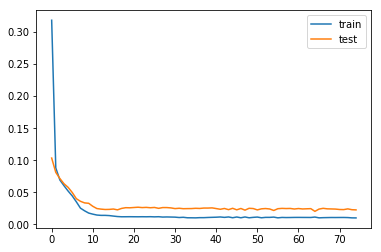

Train RMSE: 1.404
Test RMSE: 2.659
Train on 14772 samples, validate on 924 samples
Epoch 1/75
 - 2s - loss: 0.2599 - val_loss: 0.0880
Epoch 2/75
 - 1s - loss: 0.0738 - val_loss: 0.0731
Epoch 3/75
 - 1s - loss: 0.0598 - val_loss: 0.0606
Epoch 4/75
 - 1s - loss: 0.0469 - val_loss: 0.0473
Epoch 5/75
 - 1s - loss: 0.0312 - val_loss: 0.0374
Epoch 6/75
 - 1s - loss: 0.0211 - val_loss: 0.0363
Epoch 7/75
 - 1s - loss: 0.0162 - val_loss: 0.0261
Epoch 8/75
 - 0s - loss: 0.0138 - val_loss: 0.0218
Epoch 9/75
 - 0s - loss: 0.0125 - val_loss: 0.0212
Epoch 10/75
 - 0s - loss: 0.0118 - val_loss: 0.0229
Epoch 11/75
 - 0s - loss: 0.0117 - val_loss: 0.0239
Epoch 12/75
 - 0s - loss: 0.0117 - val_loss: 0.0231
Epoch 13/75
 - 0s - loss: 0.0117 - val_loss: 0.0233
Epoch 14/75
 - 0s - loss: 0.0117 - val_loss: 0.0226
Epoch 15/75
 - 0s - loss: 0.0115 - val_loss: 0.0233
Epoch 16/75
 - 0s - loss: 0.0114 - val_loss: 0.0232
Epoch 17/75
 - 0s - loss: 0.0114 - val_loss: 0.0232
Epoch 18/75
 - 1s - loss: 0.0114 - val_los

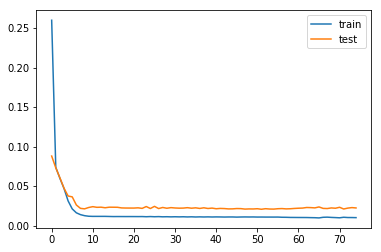

Train RMSE: 1.436
Test RMSE: 2.745
Train on 19696 samples, validate on 924 samples
Epoch 1/75
 - 2s - loss: 0.2171 - val_loss: 0.0835
Epoch 2/75
 - 1s - loss: 0.0669 - val_loss: 0.0656
Epoch 3/75
 - 1s - loss: 0.0510 - val_loss: 0.0530
Epoch 4/75
 - 1s - loss: 0.0342 - val_loss: 0.0390
Epoch 5/75
 - 1s - loss: 0.0212 - val_loss: 0.0349
Epoch 6/75
 - 1s - loss: 0.0160 - val_loss: 0.0274
Epoch 7/75
 - 1s - loss: 0.0144 - val_loss: 0.0244
Epoch 8/75
 - 1s - loss: 0.0135 - val_loss: 0.0242
Epoch 9/75
 - 1s - loss: 0.0125 - val_loss: 0.0254
Epoch 10/75
 - 1s - loss: 0.0123 - val_loss: 0.0264
Epoch 11/75
 - 1s - loss: 0.0122 - val_loss: 0.0267
Epoch 12/75
 - 1s - loss: 0.0122 - val_loss: 0.0270
Epoch 13/75
 - 1s - loss: 0.0122 - val_loss: 0.0260
Epoch 14/75
 - 1s - loss: 0.0120 - val_loss: 0.0267
Epoch 15/75
 - 1s - loss: 0.0115 - val_loss: 0.0278
Epoch 16/75
 - 1s - loss: 0.0118 - val_loss: 0.0246
Epoch 17/75
 - 1s - loss: 0.0108 - val_loss: 0.0277
Epoch 18/75
 - 1s - loss: 0.0107 - val_los

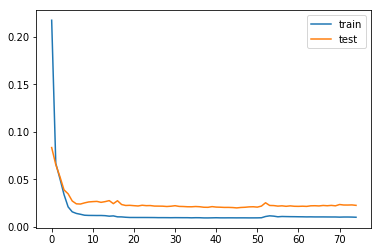

Train RMSE: 1.452
Test RMSE: 2.744
Train on 24620 samples, validate on 924 samples
Epoch 1/75
 - 2s - loss: 0.1797 - val_loss: 0.0777
Epoch 2/75
 - 1s - loss: 0.0596 - val_loss: 0.0590
Epoch 3/75
 - 1s - loss: 0.0391 - val_loss: 0.0393
Epoch 4/75
 - 1s - loss: 0.0222 - val_loss: 0.0323
Epoch 5/75
 - 1s - loss: 0.0150 - val_loss: 0.0244
Epoch 6/75
 - 1s - loss: 0.0131 - val_loss: 0.0230
Epoch 7/75
 - 1s - loss: 0.0123 - val_loss: 0.0256
Epoch 8/75
 - 1s - loss: 0.0123 - val_loss: 0.0249
Epoch 9/75
 - 1s - loss: 0.0122 - val_loss: 0.0245
Epoch 10/75
 - 1s - loss: 0.0120 - val_loss: 0.0234
Epoch 11/75
 - 1s - loss: 0.0117 - val_loss: 0.0223
Epoch 12/75
 - 1s - loss: 0.0111 - val_loss: 0.0212
Epoch 13/75
 - 1s - loss: 0.0114 - val_loss: 0.0244
Epoch 14/75
 - 1s - loss: 0.0114 - val_loss: 0.0241
Epoch 15/75
 - 1s - loss: 0.0114 - val_loss: 0.0217
Epoch 16/75
 - 1s - loss: 0.0112 - val_loss: 0.0232
Epoch 17/75
 - 1s - loss: 0.0114 - val_loss: 0.0215
Epoch 18/75
 - 1s - loss: 0.0112 - val_los

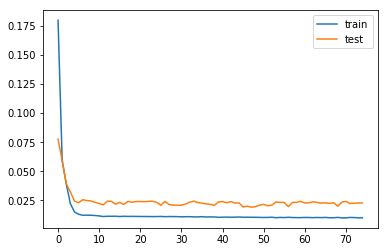

Train RMSE: 1.452
Test RMSE: 2.753
Train on 29544 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.1541 - val_loss: 0.0689
Epoch 2/75
 - 1s - loss: 0.0506 - val_loss: 0.0498
Epoch 3/75
 - 1s - loss: 0.0303 - val_loss: 0.0338
Epoch 4/75
 - 1s - loss: 0.0166 - val_loss: 0.0245
Epoch 5/75
 - 1s - loss: 0.0126 - val_loss: 0.0234
Epoch 6/75
 - 1s - loss: 0.0119 - val_loss: 0.0235
Epoch 7/75
 - 1s - loss: 0.0118 - val_loss: 0.0237
Epoch 8/75
 - 1s - loss: 0.0117 - val_loss: 0.0231
Epoch 9/75
 - 1s - loss: 0.0115 - val_loss: 0.0229
Epoch 10/75
 - 1s - loss: 0.0113 - val_loss: 0.0218
Epoch 11/75
 - 1s - loss: 0.0110 - val_loss: 0.0212
Epoch 12/75
 - 1s - loss: 0.0110 - val_loss: 0.0212
Epoch 13/75
 - 1s - loss: 0.0109 - val_loss: 0.0211
Epoch 14/75
 - 1s - loss: 0.0109 - val_loss: 0.0211
Epoch 15/75
 - 1s - loss: 0.0109 - val_loss: 0.0220
Epoch 16/75
 - 1s - loss: 0.0108 - val_loss: 0.0211
Epoch 17/75
 - 1s - loss: 0.0107 - val_loss: 0.0212
Epoch 18/75
 - 1s - loss: 0.0107 - val_los

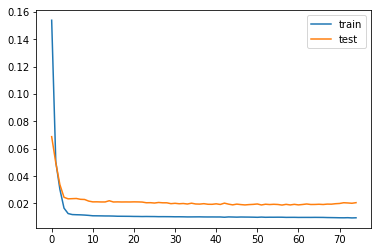

Train RMSE: 1.478
Test RMSE: 2.836


In [20]:
augmentation_size_rmse = []

augmentation_size = [1,2,3,4,5]

for i in range(0,len(augmentation_size)):
    _Xtr, _ytr = noise(X, y, augmentation_size[i], 1) #sigma 1
    augmented_X = pd.DataFrame(_Xtr)
    augmented_y = pd.DataFrame(_ytr)
    #augmented_data = pd.concat([augmented_X,augmented_y],axis=1)
    #Humidity
    augmented_data = pd.concat([augmented_X,augmented_y],axis = 1)
    augmented_data.columns = ["Temperature","Lux","IAQ","Humidity"]
    augmented_data = pd.DataFrame(augmented_data,columns=["Temperature","Humidity","Lux","IAQ"])
    augmented_values = augmented_data.values
    scaled_augmented_values = scaler.fit_transform(augmented_values)
    
    converted_time_series_augmented = series_to_supervised(scaled_augmented_values, 1, 1)
    converted_time_series_augmented.drop(converted_time_series_augmented.columns[[4,6,7]], axis=1, inplace=True)
    converted_time_series_values_augmented = converted_time_series_augmented.values
    #train_min_augmented = [20756,31134,41512,51890,62268]
    train_min_augmented = [9848,14772,19696,24620,29544]
    train_set_augmented = converted_time_series_values_augmented[:train_min_augmented[i],:]
    train_X_augmented, train_y_augmented = train_set_augmented[:, :-1], train_set_augmented[:, -1]
    train_X_augmented = train_X_augmented.reshape((train_X_augmented.shape[0], 1, train_X_augmented.shape[1]))
    test_X_r = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    temp_test = lstm_model_Humidity_for_norm_dist(train_X_augmented,train_y_augmented,test_X_r,test_y)
    augmentation_size_rmse.append(temp_test)
augmentation_size_rmse = pd.DataFrame(augmentation_size_rmse)
augmentation_size_rmse[1] = augmentation_size
augmentation_size_rmse.columns = ["Test RMSE","Augmentation Size"]

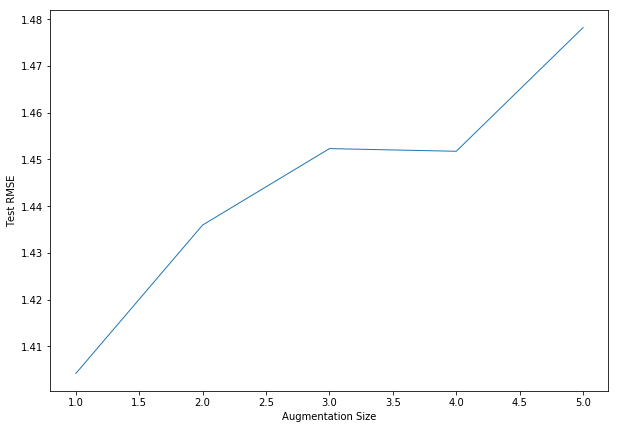

In [21]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x="Augmentation Size", y="Test RMSE",
                    estimator=None, lw=1,
                   data=augmentation_size_rmse)

In [22]:
augmentation_size_rmse.iloc[:,:1].values

array([[1.40419655],
       [1.43597661],
       [1.45232886],
       [1.4517589 ],
       [1.47823148]])

In [23]:
converted_time_series_values_augmented

array([[0.83443364, 0.56504835, 0.49326983, 0.42471845, 0.56364349],
       [0.83887855, 0.56364349, 0.47631645, 0.42851222, 0.560115  ],
       [0.84948109, 0.560115  , 0.43932295, 0.4294595 , 0.5618139 ],
       ...,
       [0.6248293 , 0.63303711, 0.55221385, 0.39289487, 0.62807109],
       [0.63847609, 0.62807109, 0.5534067 , 0.38860973, 0.61840042],
       [0.66126985, 0.61840042, 0.47365333, 0.39696042, 0.61866179]])

#  DATA AUGMENTATION WITH SMOTE REGRESSION

In [24]:
smote_dataset_x = dataset_5M.drop(dataset_5M.columns[[1]],axis = 1)
smote_dataset_y = dataset_5M.drop(dataset_5M.columns[[0,2,3]],axis = 1)

In [25]:
Smote_X_data = np.array(smote_dataset_x)
Smote_y_data = np.array(smote_dataset_y)

In [26]:
def lstm_model_Humidity_for_smote_reg(train_X_smote_augmented,train_y_smote_augmented,test_X,test_y):

    model_smote = Sequential()
    model_smote.add(LSTM(50,activation='relu', input_shape=(train_X_smote_augmented.shape[1], train_X_smote_augmented.shape[2])))

  
    model_smote.add(Dense(1))
    model_smote.compile(loss='mae', optimizer='adam')
    # fit network
    history = model_smote.fit(train_X_smote_augmented, train_y_smote_augmented, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # make a prediction
    yhat = model_smote.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]


    #make a prediction 

    yhat_train_augmented = model_smote.predict(train_X_smote_augmented)
    train_X_smote_augmented = train_X_smote_augmented.reshape((train_X_smote_augmented.shape[0], train_X_smote_augmented.shape[2]))
    # invert scaling for forecast
    inv_yhat_train_augmented = concatenate((yhat_train_augmented, train_X_smote_augmented[:, 1:]), axis=1)
    inv_yhat_train_augmented = scaler.inverse_transform(inv_yhat_train_augmented)
    inv_yhat_train_augmented = inv_yhat_train_augmented[:,0]

    # invert scaling for actual
    train_y_smote_augmented = train_y_smote_augmented.reshape((len(train_y_smote_augmented), 1))
    train_inv_y_augmented = concatenate((train_y_smote_augmented, train_X_smote_augmented[:, 1:]), axis=1)
    train_inv_y_augmented = scaler.inverse_transform(train_inv_y_augmented)
    train_inv_y_augmented = train_inv_y_augmented[:,0]



    # calculate RMSE
    rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_train = sqrt(mean_squared_error(train_inv_y_augmented, inv_yhat_train_augmented))

    print('Train RMSE: %.3f' % rmse_train)
    print('Test RMSE: %.3f' % rmse_test)
    return rmse_train

In [27]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors

def SMOTE(T,N,k):

    n_minority_samples, n_features = T.shape

    if N < 100:
  
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N < 100 veya 100'ün katı olmalı")

    N = int(N/100)
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    S = np.zeros(shape=(n_synthetic_samples, n_features))
#nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)


    for i in range(n_minority_samples):
        nn = neigh.kneighbors([T[i]], return_distance=False)
    
        for n in range(N):
            nn_index = choice(nn[0])
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    return S

Train on 9848 samples, validate on 924 samples
Epoch 1/75
 - 2s - loss: 0.2793 - val_loss: 0.0951
Epoch 2/75
 - 0s - loss: 0.0812 - val_loss: 0.0745
Epoch 3/75
 - 0s - loss: 0.0654 - val_loss: 0.0651
Epoch 4/75
 - 0s - loss: 0.0560 - val_loss: 0.0587
Epoch 5/75
 - 0s - loss: 0.0475 - val_loss: 0.0530
Epoch 6/75
 - 0s - loss: 0.0393 - val_loss: 0.0416
Epoch 7/75
 - 0s - loss: 0.0281 - val_loss: 0.0361
Epoch 8/75
 - 0s - loss: 0.0231 - val_loss: 0.0316
Epoch 9/75
 - 0s - loss: 0.0185 - val_loss: 0.0304
Epoch 10/75
 - 0s - loss: 0.0159 - val_loss: 0.0273
Epoch 11/75
 - 0s - loss: 0.0144 - val_loss: 0.0215
Epoch 12/75
 - 0s - loss: 0.0135 - val_loss: 0.0200
Epoch 13/75
 - 0s - loss: 0.0135 - val_loss: 0.0197
Epoch 14/75
 - 0s - loss: 0.0132 - val_loss: 0.0195
Epoch 15/75
 - 0s - loss: 0.0125 - val_loss: 0.0197
Epoch 16/75
 - 0s - loss: 0.0123 - val_loss: 0.0191
Epoch 17/75
 - 0s - loss: 0.0124 - val_loss: 0.0192
Epoch 18/75
 - 0s - loss: 0.0123 - val_loss: 0.0193
Epoch 19/75
 - 0s - loss: 

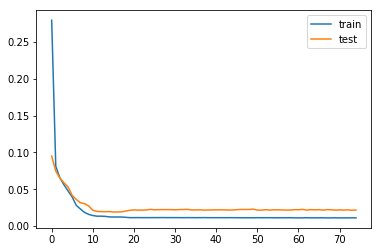

Train RMSE: 1.500
Test RMSE: 2.831
Train on 14772 samples, validate on 924 samples
Epoch 1/75
 - 2s - loss: 0.2218 - val_loss: 0.0905
Epoch 2/75
 - 0s - loss: 0.0735 - val_loss: 0.0715
Epoch 3/75
 - 0s - loss: 0.0560 - val_loss: 0.0621
Epoch 4/75
 - 0s - loss: 0.0453 - val_loss: 0.0541
Epoch 5/75
 - 0s - loss: 0.0330 - val_loss: 0.0502
Epoch 6/75
 - 0s - loss: 0.0254 - val_loss: 0.0583
Epoch 7/75
 - 0s - loss: 0.0199 - val_loss: 0.0459
Epoch 8/75
 - 0s - loss: 0.0158 - val_loss: 0.0438
Epoch 9/75
 - 0s - loss: 0.0140 - val_loss: 0.0390
Epoch 10/75
 - 0s - loss: 0.0130 - val_loss: 0.0363
Epoch 11/75
 - 0s - loss: 0.0120 - val_loss: 0.0266
Epoch 12/75
 - 0s - loss: 0.0117 - val_loss: 0.0229
Epoch 13/75
 - 0s - loss: 0.0109 - val_loss: 0.0265
Epoch 14/75
 - 0s - loss: 0.0105 - val_loss: 0.0222
Epoch 15/75
 - 0s - loss: 0.0100 - val_loss: 0.0204
Epoch 16/75
 - 0s - loss: 0.0098 - val_loss: 0.0198
Epoch 17/75
 - 0s - loss: 0.0093 - val_loss: 0.0189
Epoch 18/75
 - 0s - loss: 0.0091 - val_los

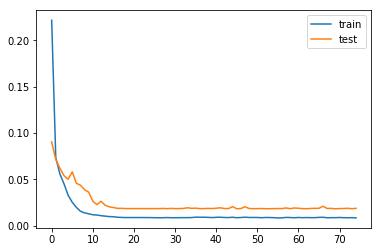

Train RMSE: 1.219
Test RMSE: 2.809
Train on 19696 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.2453 - val_loss: 0.0911
Epoch 2/75
 - 1s - loss: 0.0582 - val_loss: 0.0903
Epoch 3/75
 - 1s - loss: 0.0416 - val_loss: 0.0885
Epoch 4/75
 - 1s - loss: 0.0298 - val_loss: 0.0760
Epoch 5/75
 - 1s - loss: 0.0199 - val_loss: 0.0506
Epoch 6/75
 - 1s - loss: 0.0172 - val_loss: 0.0371
Epoch 7/75
 - 1s - loss: 0.0152 - val_loss: 0.0451
Epoch 8/75
 - 1s - loss: 0.0135 - val_loss: 0.0363
Epoch 9/75
 - 1s - loss: 0.0122 - val_loss: 0.0272
Epoch 10/75
 - 1s - loss: 0.0110 - val_loss: 0.0240
Epoch 11/75
 - 1s - loss: 0.0102 - val_loss: 0.0221
Epoch 12/75
 - 1s - loss: 0.0098 - val_loss: 0.0210
Epoch 13/75
 - 1s - loss: 0.0091 - val_loss: 0.0196
Epoch 14/75
 - 1s - loss: 0.0091 - val_loss: 0.0195
Epoch 15/75
 - 1s - loss: 0.0087 - val_loss: 0.0197
Epoch 16/75
 - 1s - loss: 0.0085 - val_loss: 0.0195
Epoch 17/75
 - 1s - loss: 0.0086 - val_loss: 0.0189
Epoch 18/75
 - 1s - loss: 0.0085 - val_los

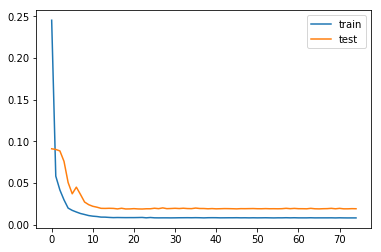

Train RMSE: 1.074
Test RMSE: 2.827
Train on 24620 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.1806 - val_loss: 0.1074
Epoch 2/75
 - 1s - loss: 0.0531 - val_loss: 0.1047
Epoch 3/75
 - 1s - loss: 0.0393 - val_loss: 0.0990
Epoch 4/75
 - 1s - loss: 0.0292 - val_loss: 0.0888
Epoch 5/75
 - 1s - loss: 0.0223 - val_loss: 0.0669
Epoch 6/75
 - 1s - loss: 0.0176 - val_loss: 0.0432
Epoch 7/75
 - 1s - loss: 0.0148 - val_loss: 0.0267
Epoch 8/75
 - 1s - loss: 0.0130 - val_loss: 0.0247
Epoch 9/75
 - 1s - loss: 0.0122 - val_loss: 0.0235
Epoch 10/75
 - 1s - loss: 0.0110 - val_loss: 0.0228
Epoch 11/75
 - 1s - loss: 0.0105 - val_loss: 0.0228
Epoch 12/75
 - 1s - loss: 0.0100 - val_loss: 0.0234
Epoch 13/75
 - 1s - loss: 0.0096 - val_loss: 0.0219
Epoch 14/75
 - 1s - loss: 0.0087 - val_loss: 0.0217
Epoch 15/75
 - 1s - loss: 0.0085 - val_loss: 0.0226
Epoch 16/75
 - 1s - loss: 0.0087 - val_loss: 0.0233
Epoch 17/75
 - 1s - loss: 0.0083 - val_loss: 0.0218
Epoch 18/75
 - 1s - loss: 0.0084 - val_los

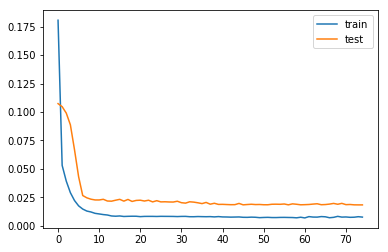

Train RMSE: 0.959
Test RMSE: 2.814
Train on 29544 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.1644 - val_loss: 0.1344
Epoch 2/75
 - 1s - loss: 0.0496 - val_loss: 0.1162
Epoch 3/75
 - 1s - loss: 0.0356 - val_loss: 0.0993
Epoch 4/75
 - 1s - loss: 0.0272 - val_loss: 0.0700
Epoch 5/75
 - 1s - loss: 0.0183 - val_loss: 0.0290
Epoch 6/75
 - 1s - loss: 0.0148 - val_loss: 0.0243
Epoch 7/75
 - 1s - loss: 0.0123 - val_loss: 0.0228
Epoch 8/75
 - 1s - loss: 0.0104 - val_loss: 0.0225
Epoch 9/75
 - 1s - loss: 0.0095 - val_loss: 0.0200
Epoch 10/75
 - 1s - loss: 0.0092 - val_loss: 0.0201
Epoch 11/75
 - 1s - loss: 0.0088 - val_loss: 0.0211
Epoch 12/75
 - 1s - loss: 0.0081 - val_loss: 0.0189
Epoch 13/75
 - 1s - loss: 0.0083 - val_loss: 0.0223
Epoch 14/75
 - 1s - loss: 0.0081 - val_loss: 0.0207
Epoch 15/75
 - 1s - loss: 0.0082 - val_loss: 0.0191
Epoch 16/75
 - 1s - loss: 0.0078 - val_loss: 0.0204
Epoch 17/75
 - 1s - loss: 0.0084 - val_loss: 0.0196
Epoch 18/75
 - 1s - loss: 0.0077 - val_los

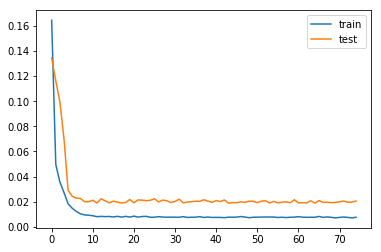

Train RMSE: 0.908
Test RMSE: 2.812


In [28]:
augmentation_size_smote_rmse = []
augmentation_size = [100,200,300,400,500]

for i in range(0,len(augmentation_size)):
    #from sklearn.neighbors import KNeighborsRegressor
    #augmented_x_smote, augmented_y_smote= smote(Smote_X_data,Smote_y_data,augmentation_size[i],5)
    from sklearn.neighbors import NearestNeighbors
    S = SMOTE(scaled,augmentation_size[i],5)
    smote_augmented_dataset = pd.DataFrame(S)
    normal_dataset = pd.DataFrame(scaled)
    smote_augmented_dataset = pd.concat([normal_dataset,smote_augmented_dataset],axis=0)
  
    #----------------
    #ugmented_x_smote = pd.DataFrame(augmented_x_smote)
    #ugmented_y_smote = pd.DataFrame(augmented_y_smote)

    #smote_augmented_dataset = augmented_x_smote
    #smote_augmented_dataset[3] = augmented_y_smote

    converted_time_series_smote_augmented = series_to_supervised(smote_augmented_dataset, 1, 1)
    converted_time_series_smote_augmented.drop(converted_time_series_smote_augmented.columns[[4,6,7]], axis=1, inplace=True)
    converted_time_series_values_smote_augmented = converted_time_series_smote_augmented.values



    train_min_smote_augmented = [9848,14772,19696,24620,29544]
    #train_min_smote_augmented = [20756,31134,41512,51890,62268]
    train_set_smote_augmented = converted_time_series_values_smote_augmented[:train_min_smote_augmented[i],:]
    
    train_X_smote_augmented, train_y_smote_augmented = train_set_smote_augmented[:, :-1], train_set_smote_augmented[:, -1]
    train_X_smote_augmented = train_X_smote_augmented.reshape((train_X_smote_augmented.shape[0], 1, train_X_smote_augmented.shape[1]))

    test_X_smote = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    temp_smote = lstm_model_Humidity_for_smote_reg(train_X_smote_augmented,train_y_smote_augmented,test_X_smote,test_y)
    augmentation_size_smote_rmse.append(temp_smote)
augmentation_size_smote_rmse = pd.DataFrame(augmentation_size_smote_rmse)
augmentation_size_smote_rmse[1] = augmentation_size
augmentation_size_smote_rmse.columns = ["Test RMSE","Augmentation Size"]

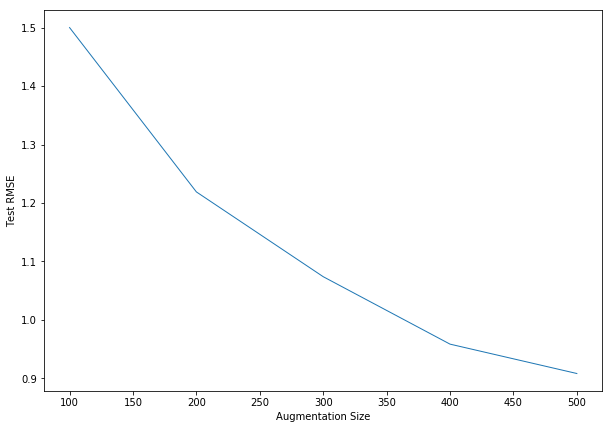

In [29]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x="Augmentation Size", y="Test RMSE",
                    estimator=None, lw=1,
                    data=augmentation_size_smote_rmse)

In [30]:
augmentation_size_smote_rmse.iloc[:,:1].values

array([[1.50002446],
       [1.218997  ],
       [1.07400648],
       [0.95866161],
       [0.90843473]])